In this project we will tackle a multi-classification problem using supervised ML on a well known dataset about red wine quality. See [here](https://www.kaggle.com/sh6147782/winequalityred). This dataset contains quality parameters for 1596 red-wines, which we can use to build a model that predicts red wine quality.

We will folow the following steps:
*Note that in this case the dataset is clean and ready to go to this is a simplified project since two of the major steps in a ML projec are not needed (Data collection and Data cleaning)*
..
   * 1) Visualize the data. In particular, see how the targets are distributed in our dataset.Analyze the attributes and perhaps perform some feature engineering
   * 2) Split the data into a test and a training set. Consider **stratifying** the dataset depending on the distribution of the targets
    
   * 3) Preprocess the training data. If data is skewed and attributes differ in scale consider **normalization or standarization**
   * 4) Evaluate different algos
   * 5) Fine tune the most promising one
   * 6) Test the model upon the testing data
   * 7) If satisfactory, productionize the model

In [146]:
# libraries needed
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
from matplotlib import cm 
from pandas.plotting import scatter_matrix
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier


from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn import metrics as m
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("winequality-red.csv")

#### 1. Visualize and analyze the data

In [21]:
df.isna().sum() # no nan values ✔

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [3]:
df.shape

(1596, 12)

In [7]:
# a mapping dictionary that maps the quality values from 0 to 5
quality_mapping = {
3: 0, 4: 1, 5: 2, 6: 3, 7: 4, 8: 5}
# you can use the map function of pandas with any dictionary 
# to convert the values in a givenncolumn to values in the dictionary

df["quality"] = df["quality"].map(quality_mapping)

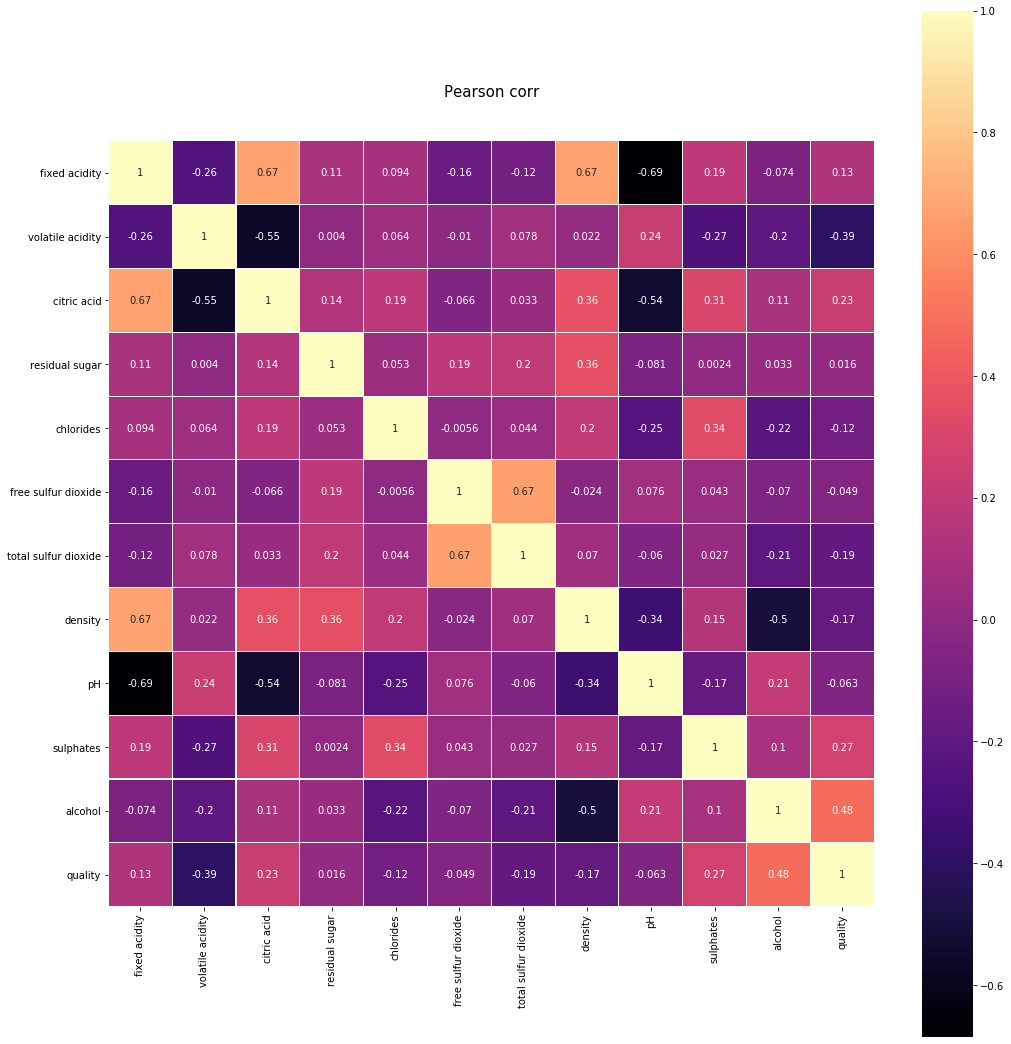

In [12]:
plt.figure(figsize=(15,15))

colormap=plt.cm.magma
plt.title("Pearson corr", y=1.05, size=15)
sns.heatmap(df.corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor="white", annot=True)
# plt.savefig("corr.png", dpi=400)
plt.tight_layout()
plt.show()

In [18]:
corr_matrix = df.corr()
corr_vals = abs(corr_matrix["quality"]).sort_values(ascending=False)
top8_corr =  corr_vals[1:9]

In [19]:
top8_corr # we will carry with these attributes for the modeling

alcohol                 0.480738
volatile acidity        0.391735
sulphates               0.270777
citric acid             0.233733
total sulfur dioxide    0.185404
density                 0.173251
fixed acidity           0.127766
chlorides               0.119770
Name: quality, dtype: float64

In [31]:
top8_corr = pd.DataFrame(top8_corr)

We observe that the atributes that correlate best with the wine quality are alcohol, volatile acicity, sulphates, citric acid, total sufur dioxide, density, fixed acidity and chlorides. We will be using these in the modeling

In [44]:
list_top8 = list(top8_corr.index)

In [46]:
list_top8.append("quality")

In [84]:
df_model = df[list_top8]

In [85]:
gist_heat = cm.get_cmap('gist_heat', 200)

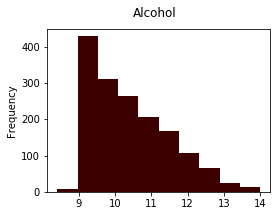

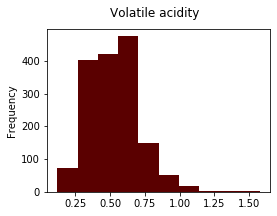

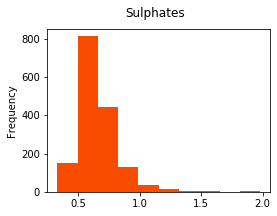

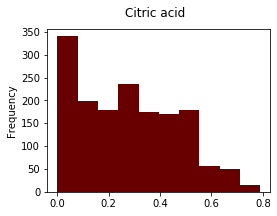

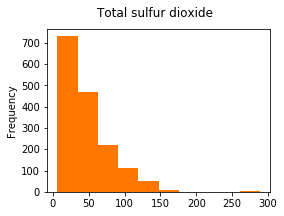

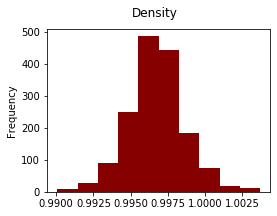

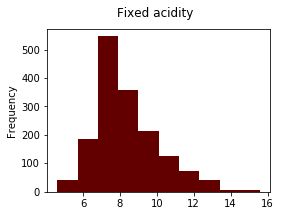

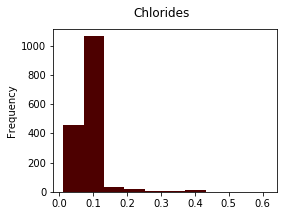

In [86]:
for i in top8_corr.index:
    df[i].plot(kind="hist", 
               subplots=True,
               figsize=(4,3), 
               title=str.capitalize(i),
               color=gist_heat(random.uniform(0, 1)))
    plt.show()

We can see that most of the selected attributes shown an skewed distribution and possess different scales. We will therefore standarized the data before modeling. But first, lets split the data into the test and train sets.

#### 2. Splitting data: 
First we check the distribution of the target values to see if an stratified split is needed

Text(0, 0.5, 'count')

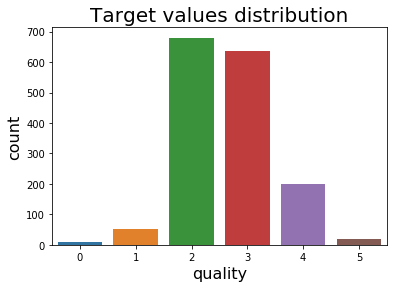

In [87]:
ax = sns.countplot(x='quality', data=df)
ax.set_title("Target values distribution", fontsize=20)
ax.set_xlabel("quality", fontsize=16)
ax.set_ylabel("count", fontsize=16)

We can see that we have a skewed dataset for classification 
so we may want to stratify the data before split. Furthermore, we will want to use **stratified k-fold cross-validation** (For classification problems).

-> There are several choices for selecting the appropriate number of bins. If
you have a lot of samples( > 10k, > 100k), then you don’t need to care about the
number of bins. Just divide the data into 10 or 20 bins. If you do not have a lot of
samples, you can use a simple rule like Sturge’s Rule to calculate the appropriate
number of bins.


Number of Bins = 1 + log2(N) Where N is the number of samples you have in your dataset. # 12 in our case

For the stratification we will use the most correlated attribute (alchohol)

In [88]:
def strater (col_item):
    if col_item <= 9.3:
        return 1
    elif col_item > 9.3 and col_item <= 10:
        return 2
    elif col_item > 10 and col_item <= 11:
        return 3
    elif col_item > 11 and col_item <= 12:
        return 4
    else:
        return 5

In [89]:
df_model["strat"] = df_model["alcohol"].apply(strater)

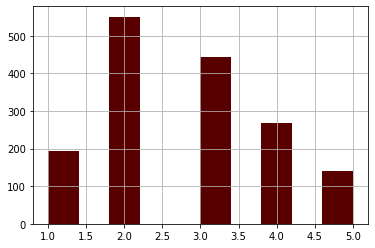

In [96]:
df_model["strat"].hist(color=gist_heat(random.uniform(0, 1)))

In [91]:
split = StratifiedShuffleSplit(n_splits = 1, test_size=0.2, random_state=10)

In [97]:
for train_index, test_index in split.split(df_model, df_model["strat"]):
    strat_train_set = df_model.loc[train_index]
    strat_test_set = df_model.loc[test_index]

In [98]:
# we will also do a random split tocompare the results of the distribution
X = df_model.drop("quality", axis=1)
y = df_model["quality"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10) # 0.2 means 80 % is in our train set and 20

In [99]:
def proportions(data):
    return data["strat"].value_counts()/len(data)

In [100]:
comparing = pd.DataFrame({"Overall": proportions(df_model),
                         "Stratified": proportions(strat_test_set),
                         "Random": proportions(X_test)}).sort_index()

In [101]:
comparing = comparing *100 

In [102]:
comparing 
# We can observe how the proportions in the stratified set are closer 
# to those in the whole set compared to the ramdomly generated set

,Overall,Stratified,Random
1,12.155388,12.1875,11.8750
2,34.523810,34.3750,33.4375
3,27.819549,27.8125,27.1875
4,16.729323,16.8750,17.5000
5,8.771930,8.7500,10.0000


In [103]:
df_model.drop("strat", axis=1, inplace=True)

In [104]:
X = df_model.drop("quality", axis=1)

we go with stratified split then:

In [105]:
strat_train_set.drop("strat", axis=1, inplace=True)
strat_test_set.drop("strat", axis=1, inplace=True)

In [106]:
X_train = strat_train_set.drop("quality", axis=1)
y_train = strat_train_set["quality"].values

In [107]:
X_test = strat_test_set.drop("quality", axis=1)
y_test = strat_test_set["quality"].values

#### 3. Re-scale data

In [108]:
scaler = StandardScaler().fit(X_train)
X_train_rescaled = scaler.transform(X_train)

In [117]:
X_train_rescaled

array([[-0.867092  , -0.99548762, -0.96367273, ...,  0.78249384,
         0.94119169, -0.07832542],
       [ 0.91822231,  0.05946165, -0.47460187, ..., -1.33889216,
        -1.56396527, -0.89536553],
       [ 0.54236667, -0.91220215,  0.74807527, ..., -0.06606056,
        -0.57355438,  0.04182754],
       ...,
       [-1.80673111, -0.82891668, -0.04666487, ...,  1.28101955,
         0.99945115,  1.98830547],
       [-0.58520027,  0.44812717, -0.04666487, ...,  0.40064436,
        -0.51529492, -0.29460074],
       [-0.67916418, -0.21815658, -0.7191373 , ..., -0.54337241,
        -0.45703545, -0.24653956]])

In [119]:
df_rescaled = pd.DataFrame(X_train_rescaled, columns=df_model.columns[:-1])

In [121]:
df_rescaled.describe()

,alcohol,volatile acidity,sulphates,citric acid,total sulfur dioxide,density,fixed acidity,chlorides
count,1.276000e+03,1.276000e+03,1.276000e+03,1.276000e+03,1.276000e+03,1.276000e+03,1.276000e+03,1.276000e+03
mean,-8.060428e-16,2.881707e-16,-2.088194e-16,9.188053e-17,5.150878e-17,-8.716678e-14,-4.301679e-16,2.394462e-16
std,1.000392e+00,1.000392e+00,1.000392e+00,1.000392e+00,1.000392e+00,1.000392e+00,1.000392e+00,1.000392e+00
min,-1.900695e+00,-2.272531e+00,-2.002948e+00,-1.392466e+00,-1.239535e+00,-3.529223e+00,-2.146560e+00,-1.784497e+00
25%,-8.670920e-01,-7.733930e-01,-6.580034e-01,-9.244664e-01,-7.278409e-01,-5.964071e-01,-6.900733e-01,-3.907231e-01
50%,-2.093446e-01,-5.158564e-02,-2.300664e-01,-9.246701e-02,-2.763460e-01,-1.302591e-02,-2.239976e-01,-1.744478e-01
75%,6.363306e-01,6.146981e-01,4.424060e-01,7.915323e-01,4.836704e-01,5.743328e-01,4.751160e-01,8.988873e-02
max,3.361284e+00,5.833921e+00,8.084138e+00,2.715531e+00,7.278669e+00,3.694096e+00,4.261981e+00,9.149422e+00


<Figure size 720x720 with 0 Axes>

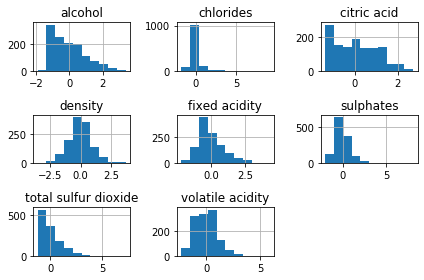

In [123]:
plt.figure(figsize=(10,10))

df_rescaled.hist()
plt.tight_layout()
plt.show()

#### 4. Exploring model performance

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC


In [133]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('SGD', SGDClassifier())) 
models.append(('GNB', GaussianNB()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('KNC', KNeighborsClassifier()))
models.append(('SVC', SVC()))

results_model = []
names_model = []
for name, model in models:
    SKF = StratifiedKFold(n_splits=12, random_state=10)
    cv_results = cross_val_score(model, X_train_rescaled, y_train, cv=SKF, scoring='f1_micro')
    results_model.append(cv_results)
    names_model.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.591680 (0.040433)
SGD: 0.538382 (0.059388)
GNB: 0.564186 (0.044275)
CART: 0.606668 (0.044654)
KNC: 0.583150 (0.048350)
SVC: 0.623817 (0.046100)


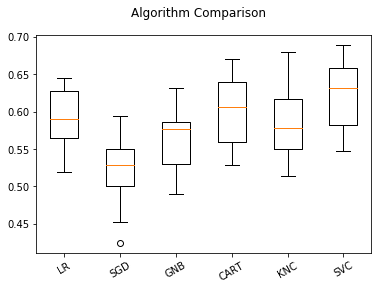

In [130]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results_model)
ax.set_xticklabels(names_model, rotation=30)
plt.show()

#### 5. Fine tune SVC

In [137]:
kernel = ["rbf"] # ["linear", "poly", "rbf", "sigmoid"] 
C = [0.1, 0.5, 1.5, 5.5, 6.5, 7.5, 8.5]

param_grid = dict(kernel=kernel, C=C)


model = SVC()
SKF = StratifiedKFold(n_splits=12, random_state=10)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring="f1_micro", cv=SKF)
grid_result = grid.fit(X_train_rescaled, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    # Best 0.623832 (0.038673) using {'C': 1.5, 'kernel': 'rbf'}

Best: 0.623832 using {'C': 1.5, 'kernel': 'rbf'}
0.584604 (0.036561) with: {'C': 0.1, 'kernel': 'rbf'}
0.614398 (0.042048) with: {'C': 0.5, 'kernel': 'rbf'}
0.623832 (0.038673) with: {'C': 1.5, 'kernel': 'rbf'}
0.615221 (0.052387) with: {'C': 5.5, 'kernel': 'rbf'}
0.617579 (0.045271) with: {'C': 6.5, 'kernel': 'rbf'}
0.623068 (0.045106) with: {'C': 7.5, 'kernel': 'rbf'}
0.622304 (0.044157) with: {'C': 8.5, 'kernel': 'rbf'}


In [148]:
SVC = SVC(kernel="rbf", C=1.5)
SVC.fit(X_train_rescaled, y_train)

SVC(C=1.5, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

#### 6. Test the model on the test_data

In [139]:
scaler = StandardScaler().fit(X_test)
X_test_rescaled = scaler.transform(X_test)

In [143]:
SVC.score(X_train_rescaled,y_train)

0.6653605015673981

In [142]:
SVC.score(X_test_rescaled,y_test)

0.6

In [149]:
predictions = SVC.predict(X_test_rescaled)
print("=====================\nF1_score:\n")
print(m.f1_score(y_test, predictions, average='weighted'))
print("=====================\nConfusion Matrix:\n")
print(m.confusion_matrix(y_test, predictions))
print("\n=================")
print(m.classification_report(y_test, predictions))


F1_score:

0.5840542978699841
Confusion Matrix:

[[  0   0   2   0   0   0]
 [  0   0   4   2   0   0]
 [  0   0 108  39   1   0]
 [  0   0  46  72   7   0]
 [  0   0   1  22  12   0]
 [  0   0   0   3   1   0]]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         6
           2       0.67      0.73      0.70       148
           3       0.52      0.58      0.55       125
           4       0.57      0.34      0.43        35
           5       0.00      0.00      0.00         4

    accuracy                           0.60       320
   macro avg       0.29      0.27      0.28       320
weighted avg       0.58      0.60      0.58       320



We see that we hit a 60% of predictions correcly, and as we can appreciate in the confusion matrix, most of errors fall by one point of quality(+-1), meaning that we can use our model to estimate the quality of red wine

In [152]:
pd.Series(y_test).value_counts()

2    148
3    125
4     35
1      6
5      4
0      2
dtype: int64